## Libraries

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import plotly.express as px
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import pandas as pd 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
from neo4j import GraphDatabase
from pm4py.objects.log.obj import EventLog, Trace
import pm4py
import numpy as np
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Connect to Neo4J database

In [37]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "Croma2023"))
session = driver.session()

## Retrieve data 

In [38]:
query = f'''MATCH (e:Event) - [:CORR] -> (n:Run)
where not e:OnlyKitEvent
Optional match (e) - [:WASHED_IN] -> (w:WashingMachine)
Optional match (e) - [:WASHED_ON] -> (r:Rack)
Optional match (e) - [:STERILIZED_IN] -> (s:SterilizationMachine)
RETURN e.CaseID, e.KitID, n.startTimestamp, n.endTimestamp, e.Activity, e.Usuario, e.timestamp, w.machine, r.name, s.machine, s.type, e.batchID'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
df = pd.DataFrame(records, columns=columns)
df['e.timestamp'] = pd.to_datetime(df['e.timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
df.head()

,e.CaseID,e.KitID,n.startTimestamp,n.endTimestamp,e.Activity,e.Usuario,e.timestamp,w.machine,r.name,s.machine,s.type,e.batchID
0,HNB-OFT.002-10-CN31636,HNB-OFT.002-10,2022-03-31T20:30:00.000000000+00:00,2022-03-31T21:08:00.000000000+00:00,Carga L+D iniciada,MMF,2022-03-31 21:08:00+00:00,None,None,None,None,b13537
1,HNB-OFT.002-10-CN31636,HNB-OFT.002-10,2022-03-31T20:30:00.000000000+00:00,2022-03-31T21:08:00.000000000+00:00,Cargado en carro L+D,MMF,2022-03-31 21:08:00+00:00,None,None,None,None,b13537
2,HNB-OFT.002-10-CN31636,HNB-OFT.002-10,2022-03-31T20:30:00.000000000+00:00,2022-03-31T21:08:00.000000000+00:00,Entrada Material Sucio,MMF,2022-03-31 20:30:00+00:00,None,None,None,None,b0
3,HNB-OFT.002-19-CN31637,HNB-OFT.002-19,2022-03-31T20:30:00.000000000+00:00,2022-03-31T21:08:00.000000000+00:00,Carga L+D iniciada,MMF,2022-03-31 21:08:00+00:00,None,None,None,None,b13537
4,HNB-OFT.002-19-CN31637,HNB-OFT.002-19,2022-03-31T20:30:00.000000000+00:00,2022-03-31T21:08:00.000000000+00:00,Cargado en carro L+D,MMF,2022-03-31 21:08:00+00:00,None,None,None,None,b13537


In [39]:
df.describe()

,e.CaseID,e.KitID,n.startTimestamp,n.endTimestamp,e.Activity,e.Usuario,e.timestamp,w.machine,r.name,s.machine,s.type,e.batchID
count,227672,227672,227672,227672,227672,227672,227672,12288,12288,9600,9600,227672
unique,19524,2052,7136,3198,9,20,29217,8,15,6,2,40338
top,EXT-GAFAS-0-CN32736,EXT-GAFAS-0,2022-02-28T21:43:00.000000000+00:00,2022-03-31T20:46:00.000000000+00:00,Producción montada,MCE,2022-03-04 17:03:00+00:00,Lavadora 2,Rack-Lav. 01,Autoclave 2,High Temperature Sterilization,b194276
freq,3290,22226,3290,5900,37931,20530,205,3484,2095,2722,9224,237
first,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 07:09:00+00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-31 21:54:00+00:00,NaN,NaN,NaN,NaN,NaN


In [40]:
event_log = pm4py.format_dataframe(df, case_id='e.CaseID', activity_key='e.Activity', timestamp_key='e.timestamp')
#event_log = pm4py.convert_to_event_log(event_log)
event_log

,case:concept:name,e.KitID,n.startTimestamp,n.endTimestamp,concept:name,e.Usuario,time:timestamp,w.machine,r.name,s.machine,s.type,e.batchID,@@index
202580,012047 L2901-0-CN10604,012047 L2901-0,2022-01-26T17:31:00.000000000+00:00,2022-01-28T08:16:00.000000000+00:00,Montaje,CM,2022-01-26 17:31:00+00:00,None,None,None,None,b99846,202580
202581,012047 L2901-0-CN10604,012047 L2901-0,2022-01-26T17:31:00.000000000+00:00,2022-01-28T08:16:00.000000000+00:00,Montaje,SM,2022-01-28 08:16:00+00:00,None,None,None,None,b99434,202581
223286,012047 L2901-0-CN1069,012047 L2901-0,2022-01-04T16:00:00.000000000+00:00,2022-01-07T13:06:00.000000000+00:00,Montaje,CM,2022-01-04 16:00:00+00:00,None,None,None,None,b105200,223286
223282,012047 L2901-0-CN1069,012047 L2901-0,2022-01-04T16:00:00.000000000+00:00,2022-01-07T13:06:00.000000000+00:00,Montaje,CM,2022-01-05 14:04:00+00:00,None,None,None,None,b105069,223282
223287,012047 L2901-0-CN1069,012047 L2901-0,2022-01-04T16:00:00.000000000+00:00,2022-01-07T13:06:00.000000000+00:00,Producción montada,CM,2022-01-05 14:04:00+00:00,None,None,None,None,b105069,223287
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215255,TRAN-QUI.TRA.ZIMMER-2-CN5066,TRAN-QUI.TRA.ZIMMER-2,2022-01-14T13:04:00.000000000+00:00,2022-01-14T21:12:00.000000000+00:00,Comisionado,MMF,2022-01-14 21:12:00+00:00,None,None,None,None,b236948,215255
39550,TRAN-QUI.TRA.ZIMMER-6-CN33281,TRAN-QUI.TRA.ZIMMER-6,2022-03-08T14:30:00.000000000+00:00,2022-03-08T17:55:00.000000000+00:00,Producción montada,BM,2022-03-08 14:30:00+00:00,None,None,None,None,b117519,39550
39551,TRAN-QUI.TRA.ZIMMER-6-CN33281,TRAN-QUI.TRA.ZIMMER-6,2022-03-08T14:30:00.000000000+00:00,2022-03-08T17:55:00.000000000+00:00,Montaje,BM,2022-03-08 14:30:00+00:00,None,None,None,None,b89161,39551
39553,TRAN-QUI.TRA.ZIMMER-6-CN33281,TRAN-QUI.TRA.ZIMMER-6,2022-03-08T14:30:00.000000000+00:00,2022-03-08T17:55:00.000000000+00:00,Composición de cargas,PN,2022-03-08 16:09:00+00:00,None,None,None,None,b155253,39553


In [41]:
original_df = event_log.copy()
original_df.fillna('NaN', inplace=True)

In [42]:
event_log = pm4py.convert_to_event_log(event_log)

## Split train test


In [43]:
prefix_traces = []
for trace in event_log:
    trace_end_flag = False
    for i,event in enumerate(trace):
        if "Comisionado" in event['concept:name']:
            trace_end_flag = True
            i+=1
            break
        if "Carga de esterilizador liberada" in event['concept:name']:
            trace_end_flag = True
    if trace_end_flag:
        prefix_traces.append(Trace(trace[:i], attributes = trace.attributes))
prefix_traces = EventLog(prefix_traces)

In [44]:
trace = pm4py.convert_to_dataframe(prefix_traces)
trace.head()


,e.KitID,n.startTimestamp,n.endTimestamp,concept:name,e.Usuario,time:timestamp,w.machine,r.name,s.machine,s.type,e.batchID,@@index,case:concept:name
0,012047 L2901-0,2022-01-13T20:35:00.000000000+00:00,2022-01-14T17:47:00.000000000+00:00,Producción montada,CM,2022-01-13 20:35:00+00:00,None,None,None,None,b103095,215379,012047 L2901-0-CN4774
1,012047 L2901-0,2022-01-13T20:35:00.000000000+00:00,2022-01-14T17:47:00.000000000+00:00,Montaje,CM,2022-01-13 20:35:00+00:00,None,None,None,None,b103095,215382,012047 L2901-0-CN4774
2,012047 L2901-0,2022-01-13T20:35:00.000000000+00:00,2022-01-14T17:47:00.000000000+00:00,Composición de cargas,ML,2022-01-14 14:57:00+00:00,None,None,None,None,b177161,215381,012047 L2901-0-CN4774
3,012047 L2901-0,2022-01-13T20:35:00.000000000+00:00,2022-01-14T17:47:00.000000000+00:00,Carga de esterilizador liberada,ML,2022-01-14 16:23:00+00:00,None,None,None,None,b214456,215380,012047 L2901-0-CN4774
4,DEP-QUI.BTF-1,2022-01-12T09:04:00.000000000+00:00,2022-01-12T21:42:00.000000000+00:00,Entrada Material Sucio,EH,2022-01-12 09:04:00+00:00,None,None,None,None,b12558,121434,DEP-QUI.BTF-1-CN3732


In [45]:
# get completion time and sort
completion_time_ls = list(trace.groupby(['case:concept:name'])['time:timestamp'].max())
completion_time_ls = sorted(completion_time_ls)

In [46]:
# split on 70% max time 
train_split_portion = 0.70
val_split_seperation = 0.85
total_data = len(completion_time_ls)
train_len = int(train_split_portion*total_data)
val_len = int(val_split_seperation*total_data)
last_train_completion_time = completion_time_ls[train_len]
last_val_completion_time = completion_time_ls[val_len]
val_start_time = last_train_completion_time
last_train_completion_time,last_val_completion_time

(Timestamp('2022-03-01 18:43:00+0000', tz='UTC'),
 Timestamp('2022-03-17 15:09:00+0000', tz='UTC'))

In [47]:
# take all traces where start dates are after the last_train_completion_time
dtype_list = list(trace.dtypes) # get original types of the columns
train_df = pd.DataFrame(columns = trace.columns)
test_df = pd.DataFrame(columns = trace.columns)
val_df = pd.DataFrame(columns = trace.columns)
train_count,test_count,val_count = 0,0,0
intersecting_traces = []
for name, group in trace.groupby(['case:concept:name'],as_index=False):
    if group['time:timestamp'].iloc[-1] <= last_train_completion_time:
        train_df = train_df.append(group)
        train_count+=1
    # elif (group['startTime'].iloc[0] >= last_train_completion_time) and (group['completeTime'].iloc[-1] <= last_val_completion_time):
    elif group['time:timestamp'].iloc[-1] <= last_val_completion_time:
        val_df = val_df.append(group)
        val_count+=1        
    # elif group['startTime'].iloc[0] >= last_val_completion_time:
    #     test_df = test_df.append(group)
    #     test_count+=1
    else:
        test_df = test_df.append(group)
        test_count+=1
        # intersecting_traces.append(group)


# converting train and test to their original data types
for i,col in enumerate(train_df.columns):
    train_df[col] = train_df[col].astype(dtype_list[i])

for i,col in enumerate(test_df.columns):
    test_df[col] = test_df[col].astype(dtype_list[i])

for i,col in enumerate(val_df.columns):
    val_df[col] = val_df[col].astype(dtype_list[i])


print("train, val and test count")
print(train_count,val_count,test_count)

train, val and test count
11396 2442 2435


## Data encoding

In [48]:
def get_ohe_dict(categorical_vars, df):
    ohe_dict = {}
    for var in categorical_vars:
        var_dict = {}
        print(df[var].unique())
        var_data = sorted(df[var].unique())
        var_len = len(var_data)
        for i,cat in enumerate(var_data):
            var_dict[cat] = [0]*var_len
            var_dict[cat][i] = 1

        ohe_dict[var] = var_dict

    return ohe_dict

In [49]:
# function to save the data
def save_data(X,y,feature_names, save_path):
    data_dict = {}
    data_dict['X'] = X
    data_dict['y'] = y
    data_dict['feature_names'] = feature_names

    # save pickle
    with open(save_path, 'wb') as handle:
        pickle.dump(data_dict, handle)

In [50]:
def load_data(load_path):
    with open(load_path, 'rb') as handle:
        data = pickle.load(handle)
    return data

### Train data

In [51]:
t_length = 10
save_path_base = '/Users/abdalrhman/Documents/bdma-thesis/python/data/'
df_type = 'train'
permits = train_df

In [52]:
trace_log = pm4py.format_dataframe(permits, case_id='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
trace_log = pm4py.convert_to_event_log(trace_log)

In [53]:
is_delayed = []
for trace in trace_log:
    flag = False
    for i,event in enumerate(trace):
        if (not event['n.startTimestamp'] and not event['n.endTimestamp']):
            continue
        startTimestamp = pd.to_datetime(event['n.startTimestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
        finishTimestamp = pd.to_datetime(event['n.endTimestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')

        duration_minutes = (finishTimestamp - startTimestamp).total_seconds() / 60

        if duration_minutes > 370:
            flag = True
            break
    
    if flag:
        is_delayed.append(1)
    else:
        is_delayed.append(0)

In [54]:
prefix_traces = []
for trace in trace_log:
    for i,event in enumerate(trace):
        if ("Comisionado" not in event['concept:name']) or ("Carga de esterilizador liberada" not in event['concept:name']):
            break
    prefix_traces.append(Trace(trace[:i], attributes = trace.attributes))
prefix_traces = EventLog(prefix_traces)

In [55]:
trace_prefixes = EventLog([Trace(trace[0:t_length], attributes = trace.attributes) for trace in prefix_traces])

In [56]:
df = pm4py.convert_to_dataframe(trace_log)
df.head(5)

,e.KitID,n.startTimestamp,n.endTimestamp,concept:name,e.Usuario,time:timestamp,w.machine,r.name,s.machine,s.type,e.batchID,@@index,case:concept:name
0,012047 L2901-0,2022-01-13T20:35:00.000000000+00:00,2022-01-14T17:47:00.000000000+00:00,Producción montada,CM,2022-01-13 20:35:00+00:00,None,None,None,None,b103095,0,012047 L2901-0-CN4774
1,012047 L2901-0,2022-01-13T20:35:00.000000000+00:00,2022-01-14T17:47:00.000000000+00:00,Montaje,CM,2022-01-13 20:35:00+00:00,None,None,None,None,b103095,1,012047 L2901-0-CN4774
2,012047 L2901-0,2022-01-13T20:35:00.000000000+00:00,2022-01-14T17:47:00.000000000+00:00,Composición de cargas,ML,2022-01-14 14:57:00+00:00,None,None,None,None,b177161,2,012047 L2901-0-CN4774
3,012047 L2901-0,2022-01-13T20:35:00.000000000+00:00,2022-01-14T17:47:00.000000000+00:00,Carga de esterilizador liberada,ML,2022-01-14 16:23:00+00:00,None,None,None,None,b214456,3,012047 L2901-0-CN4774
4,DEP-QUI.BTF-1,2022-01-12T09:04:00.000000000+00:00,2022-01-12T21:42:00.000000000+00:00,Entrada Material Sucio,EH,2022-01-12 09:04:00+00:00,None,None,None,None,b12558,4,DEP-QUI.BTF-1-CN3732


In [57]:
cases = list(df.groupby(['case:concept:name'],sort=False)['e.KitID'].first().keys())
df_dict = dict()
df_dict['case:concept:name'] = cases
df_dict['is_delayed'] = is_delayed
temp_df = pd.DataFrame(df_dict)

# merge target variable with permits
df = df.merge(temp_df,on=['case:concept:name'])
df.drop(columns=['n.endTimestamp', 'time:timestamp', '@@index', 'n.startTimestamp'], inplace=True)
df.head()

,e.KitID,concept:name,e.Usuario,w.machine,r.name,s.machine,s.type,e.batchID,case:concept:name,is_delayed
0,012047 L2901-0,Producción montada,CM,None,None,None,None,b103095,012047 L2901-0-CN4774,1
1,012047 L2901-0,Montaje,CM,None,None,None,None,b103095,012047 L2901-0-CN4774,1
2,012047 L2901-0,Composición de cargas,ML,None,None,None,None,b177161,012047 L2901-0-CN4774,1
3,012047 L2901-0,Carga de esterilizador liberada,ML,None,None,None,None,b214456,012047 L2901-0-CN4774,1
4,DEP-QUI.BTF-1,Entrada Material Sucio,EH,None,None,None,None,b12558,DEP-QUI.BTF-1-CN3732,1


In [58]:
save_path = save_path_base + df_type +'_trace_len_'+str(t_length)+ '.csv'
df.to_csv(save_path,index=False)

In [59]:
str_ev_attr = ['concept:name', 'e.Usuario', 'w.machine', 'r.name', 's.machine',	's.type']
str_tr_attr = ['e.KitID']
categorical_vars = str_ev_attr + str_tr_attr
ohe_dict = get_ohe_dict(categorical_vars, original_df)
categorical_vars

['Montaje' 'Producción montada' 'Carga L+D iniciada' 'Carga L+D liberada'
 'Composición de cargas' 'Carga de esterilizador liberada'
 'Entrada Material Sucio' 'Cargado en carro L+D' 'Comisionado']
['CM' 'SM' 'BM' 'ML' 'AV' 'MCE' 'LI' 'ER' 'PN' 'MMF' 'EH' 'MR' 'VS' 'PG'
 'CLE' 'VA' 'SP' 'MAA' 'DF' 'MGP']
['NaN' 'Lavadora 3' 'Lavadora 2' 'Lavadora 1' 'Lavadora 4' 'Jupiter'
 'Esclusa Lavado' 'Esclusa Reposicion' 'Esclusa Caducado']
['NaN' 'Rack-Lav. 03' 'Rack-Lav. 05' 'Rack-Lav. 06' 'Rack-Lav. 04'
 'Rack-Lav. 01' 'Rack-Lav. 07' 'Rack-Lav. 10' 'Rack-Lav. 09'
 'Rack-Lav. 02' 'Rack-Lav. 08' 'Rack-Jupiter 02' 'Rack-Jupiter 01'
 'Esclusa 03' 'Esclusa 02' 'Esclusa 01']
['NaN' 'Autoclave 1' 'Autoclave 4' 'Autoclave 2' 'Autoclave 3'
 'Amsco Vpro' 'Amsco Eagle']
['NaN' 'High Temperature Sterilization' 'Low Temperature Sterilization']
['012047 L2901-0' 'CONT-CCEE.ALE-1' 'CONT-CCEE.CG-1' ...
 'TRAN-QUI.TRA.ZIMMER-1' 'TRAN-QUI.TRA.ZIMMER-2' 'TRAN-QUI.TRA.ZIMMER-6']


['concept:name',
 'e.Usuario',
 'w.machine',
 'r.name',
 's.machine',
 's.type',
 'e.KitID']

In [60]:
data = []

for id, group in df.groupby(['case:concept:name']):
    feature_vec = []

    # add categorical and numerical event attributes
    for cat_atr in str_ev_attr[:1]:
        attr_length = len(list(ohe_dict[cat_atr].values())[0])
        str_ev_vec = np.array([0]*attr_length)

        for ca in group[cat_atr]:
            str_ev_vec  = str_ev_vec + np.array(ohe_dict[cat_atr][ca])

        feature_vec.extend(list(str_ev_vec))

    data.append(feature_vec)

In [61]:
encode_name = 'frequency_encode_'
save_path = save_path_base + encode_name + df_type +'_trace_len_'+str(t_length)+ '.pickle'
save_data(data, is_delayed, ohe_dict ,save_path)

### Test data

In [62]:
df_type = 'test'
permits = test_df

In [63]:
test_df.head()

,e.KitID,n.startTimestamp,n.endTimestamp,concept:name,e.Usuario,time:timestamp,w.machine,r.name,s.machine,s.type,e.batchID,@@index,case:concept:name
77,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Entrada Material Sucio,MMF,2022-03-30 15:41:00+00:00,None,None,None,None,b320,1716,DEP-QUI.CPL.SYNTHES-1-CN31909
78,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Cargado en carro L+D,MMF,2022-03-30 16:02:00+00:00,None,None,None,None,b13915,1721,DEP-QUI.CPL.SYNTHES-1-CN31909
79,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Carga L+D iniciada,PG,2022-03-30 16:37:00+00:00,None,None,None,None,b33633,1720,DEP-QUI.CPL.SYNTHES-1-CN31909
80,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Carga L+D liberada,SP,2022-03-30 17:50:00+00:00,None,None,None,None,b58332,1718,DEP-QUI.CPL.SYNTHES-1-CN31909
81,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Montaje,EH,2022-03-30 17:55:00+00:00,None,None,None,None,b82117,1723,DEP-QUI.CPL.SYNTHES-1-CN31909


In [64]:
event_log = pm4py.format_dataframe(permits, case_id='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
event_log = pm4py.convert_to_event_log(event_log)
event_log

[{'attributes': {'concept:name': 'DEP-QUI.CPL.SYNTHES-1-CN31909'}, 'events': [{'e.KitID': 'DEP-QUI.CPL.SYNTHES-1', 'n.startTimestamp': neo4j.time.DateTime(2022, 3, 30, 15, 41, 0, 0, tzinfo=<UTC>), 'n.endTimestamp': neo4j.time.DateTime(2022, 3, 30, 20, 37, 0, 0, tzinfo=<UTC>), 'concept:name': 'Entrada Material Sucio', 'e.Usuario': 'MMF', 'time:timestamp': Timestamp('2022-03-30 15:41:00+0000', tz='UTC'), 'w.machine': None, 'r.name': None, 's.machine': None, 's.type': None, 'e.batchID': 'b320', '@@index': 77}, '..', {'e.KitID': 'DEP-QUI.CPL.SYNTHES-1', 'n.startTimestamp': neo4j.time.DateTime(2022, 3, 30, 15, 41, 0, 0, tzinfo=<UTC>), 'n.endTimestamp': neo4j.time.DateTime(2022, 3, 30, 20, 37, 0, 0, tzinfo=<UTC>), 'concept:name': 'Composición de cargas', 'e.Usuario': 'PN', 'time:timestamp': Timestamp('2022-03-30 18:11:00+0000', tz='UTC'), 'w.machine': None, 'r.name': None, 's.machine': None, 's.type': None, 'e.batchID': 'b144681', '@@index': 83}]}, '....', {'attributes': {'concept:name': 'TR

In [65]:
is_delayed = []
for trace in event_log:
    flag = False
    for i,event in enumerate(trace):
        if (not event['n.startTimestamp'] and not event['n.endTimestamp']):
            continue
        startTimestamp = pd.to_datetime(event['n.startTimestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
        finishTimestamp = pd.to_datetime(event['n.endTimestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')

        duration_minutes = (finishTimestamp - startTimestamp).total_seconds() / 60

        if duration_minutes > 370:
            flag = True
            break
    
    if flag:
        is_delayed.append(1)
    else:
        is_delayed.append(0)

In [66]:
prefix_traces = []
for trace in event_log:
    for i,event in enumerate(trace):
        if ("Comisionado" not in event['concept:name']) or ("Carga de esterilizador liberada" not in event['concept:name']):
            break
    prefix_traces.append(Trace(trace[:i], attributes = trace.attributes))
prefix_traces = EventLog(prefix_traces)

In [67]:
trace_prefixes = EventLog([Trace(trace[0:t_length], attributes = trace.attributes) for trace in prefix_traces])

In [68]:
df = pm4py.convert_to_dataframe(event_log)
df.head(5)

,e.KitID,n.startTimestamp,n.endTimestamp,concept:name,e.Usuario,time:timestamp,w.machine,r.name,s.machine,s.type,e.batchID,@@index,case:concept:name
0,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Entrada Material Sucio,MMF,2022-03-30 15:41:00+00:00,None,None,None,None,b320,77,DEP-QUI.CPL.SYNTHES-1-CN31909
1,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Cargado en carro L+D,MMF,2022-03-30 16:02:00+00:00,None,None,None,None,b13915,78,DEP-QUI.CPL.SYNTHES-1-CN31909
2,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Carga L+D iniciada,PG,2022-03-30 16:37:00+00:00,None,None,None,None,b33633,79,DEP-QUI.CPL.SYNTHES-1-CN31909
3,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Carga L+D liberada,SP,2022-03-30 17:50:00+00:00,None,None,None,None,b58332,80,DEP-QUI.CPL.SYNTHES-1-CN31909
4,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Montaje,EH,2022-03-30 17:55:00+00:00,None,None,None,None,b82117,81,DEP-QUI.CPL.SYNTHES-1-CN31909


In [69]:
cases = list(df.groupby(['case:concept:name'],sort=False)['e.KitID'].first().keys())
df_dict = dict()
df_dict['case:concept:name'] = cases
df_dict['is_delayed'] = is_delayed
temp_df = pd.DataFrame(df_dict)
df.drop(columns=['n.endTimestamp', 'time:timestamp', '@@index', 'n.startTimestamp'], inplace=True)

# merge target variable with permits
df = df.merge(temp_df,on=['case:concept:name'])
df.head()

,e.KitID,concept:name,e.Usuario,w.machine,r.name,s.machine,s.type,e.batchID,case:concept:name,is_delayed
0,DEP-QUI.CPL.SYNTHES-1,Entrada Material Sucio,MMF,None,None,None,None,b320,DEP-QUI.CPL.SYNTHES-1-CN31909,0
1,DEP-QUI.CPL.SYNTHES-1,Cargado en carro L+D,MMF,None,None,None,None,b13915,DEP-QUI.CPL.SYNTHES-1-CN31909,0
2,DEP-QUI.CPL.SYNTHES-1,Carga L+D iniciada,PG,None,None,None,None,b33633,DEP-QUI.CPL.SYNTHES-1-CN31909,0
3,DEP-QUI.CPL.SYNTHES-1,Carga L+D liberada,SP,None,None,None,None,b58332,DEP-QUI.CPL.SYNTHES-1-CN31909,0
4,DEP-QUI.CPL.SYNTHES-1,Montaje,EH,None,None,None,None,b82117,DEP-QUI.CPL.SYNTHES-1-CN31909,0


In [70]:
save_path = save_path_base + df_type +'_trace_len_'+str(t_length)+ '.csv'
df.to_csv(save_path,index=False)

In [71]:
encode_name = 'frequency_encode_'
save_path = save_path_base + encode_name + 'train' +'_trace_len_'+str(t_length)+ '.pickle'
loaded_data = load_data(save_path)
ohe_dict = loaded_data['feature_names']

In [72]:
data = []

for id, group in df.groupby(['case:concept:name']):
    feature_vec = []

    # add categorical and numerical event attributes
    for cat_atr in str_ev_attr[:1]:
        attr_length = len(list(ohe_dict[cat_atr].values())[0])
        str_ev_vec = np.array([0]*attr_length)

        for ca in group[cat_atr]:
            str_ev_vec  = str_ev_vec + np.array(ohe_dict[cat_atr][ca])

        feature_vec.extend(list(str_ev_vec))

    data.append(feature_vec)

In [73]:
encode_name = 'frequency_encode_'
save_path = save_path_base + encode_name + df_type +'_trace_len_'+str(t_length)+ '.pickle'
save_data(data, is_delayed, ohe_dict ,save_path)

## Modeling

In [74]:
data_test = load_data(save_path_base + "frequency_encode_test_trace_len_10.pickle")
data_train = load_data(save_path_base + "frequency_encode_train_trace_len_10.pickle")

In [75]:
X_train = np.array(data_train['X'])
X_test = np.array(data_test['X'])
y_train = np.array(data_train['y'])
y_test = np.array(data_test['y'])

In [76]:
results_df = pd.DataFrame(index=['Decision Tree (Default)'],
                          columns=['F-score', 'Precision','Recall', 'Accuracy'])

In [77]:
len(y_test)

2435

In [78]:
# Create Decision Tree classifier object
dt = DecisionTreeClassifier()

# Train Decision Tree Classifier
dt_fit = dt.fit(X_train,y_train)

#Predict the response for test dataset
dt_predict = dt_fit.predict(X_test)

results_df.loc['Decision Tree (Default)',:] = [f1_score(y_test,dt_predict, average='macro'), precision_score(y_test,dt_predict), recall_score(y_test,dt_predict),accuracy_score(y_test,dt_predict)]

results_df.sort_values(by='F-score', ascending=False)

,F-score,Precision,Recall,Accuracy
Decision Tree (Default),0.590063,0.904545,0.22795,0.714579


[Text(0.5131054452466908, 0.9772727272727273, 'x[3] <= 0.5\ngini = 0.499\nsamples = 11396\nvalue = [5948, 5448]'),
 Text(0.26865692689530685, 0.9318181818181818, 'x[7] <= 1.5\ngini = 0.331\nsamples = 5164\nvalue = [4082, 1082]'),
 Text(0.13431671179302046, 0.8863636363636364, 'x[6] <= 0.5\ngini = 0.248\nsamples = 4013\nvalue = [3430, 583]'),
 Text(0.08572126955475332, 0.8409090909090909, 'x[8] <= 0.5\ngini = 0.24\nsamples = 3959\nvalue = [3408, 551]'),
 Text(0.04016245487364621, 0.7954545454545454, 'x[5] <= 0.5\ngini = 0.355\nsamples = 286\nvalue = [220, 66]'),
 Text(0.02256317689530686, 0.75, 'x[0] <= 0.5\ngini = 0.199\nsamples = 223\nvalue = [198, 25]'),
 Text(0.017749699157641397, 0.7045454545454546, 'x[2] <= 1.5\ngini = 0.034\nsamples = 117\nvalue = [115, 2]'),
 Text(0.015342960288808664, 0.6590909090909091, 'gini = 0.0\nsamples = 70\nvalue = [70, 0]'),
 Text(0.020156438026474127, 0.6590909090909091, 'x[2] <= 2.5\ngini = 0.081\nsamples = 47\nvalue = [45, 2]'),
 Text(0.0177496991576

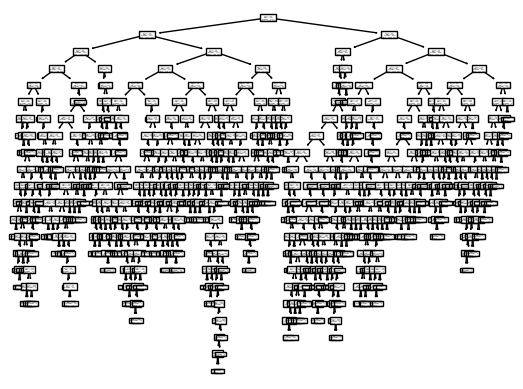

In [79]:
tree.plot_tree(dt_fit)

In [80]:
# Training the Logistic Regression model on the Training set
lr = LogisticRegression(random_state=10)
lr_fit = lr.fit(X_train, y_train)
# Predicting the Test set results
lr_predict = lr_fit.predict(X_test)

results_df.loc['Logistic Regression (Default)',:] = [f1_score(y_test,lr_predict, average='macro'), precision_score(y_test,lr_predict), recall_score(y_test,lr_predict),accuracy_score(y_test,lr_predict)]

results_df.sort_values(by='F-score', ascending=False)

,F-score,Precision,Recall,Accuracy
Decision Tree (Default),0.590063,0.904545,0.22795,0.714579
Logistic Regression (Default),0.528784,0.927536,0.146621,0.689938


In [81]:
solvers = ['lbfgs','newton-cg','liblinear','sag','saga']
penalty = ['l2', 'None']
c_values = [100, 10, 1.0, 0.1, 0.01]
max_iteration= [100, 200, 500, 1000, 2000, 5000]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values,max_iter=max_iteration)

lr_grid = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
lr_grid_fit = lr_grid.fit(X_train, y_train)

cross_val_results = pd.DataFrame(cross_validate(lr_grid.best_estimator_, X_train, y_train, scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['Logistic Regression (Grid CV Tuning)',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.sort_values(by='F-score', ascending=False)


/Users/abdalrhman/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/abdalrhman/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/abdalrhman/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/abdalrhman/Library/Python/3.9/lib/python/site-packages/sklearn/lin

,F-score,Precision,Recall,Accuracy
Logistic Regression (Grid CV Tuning),0.733817,0.747034,0.739033,0.739477
Decision Tree (Default),0.590063,0.904545,0.22795,0.714579
Logistic Regression (Default),0.528784,0.927536,0.146621,0.689938


In [82]:
randomForestModel=RandomForestClassifier(n_estimators=75)
randomForestModel.fit(X_train,y_train)
y_pred=randomForestModel.predict(X_test)

In [83]:
print('Accuracy Score: ',accuracy_score(y_test,y_pred))
print('Recall Score: ',recall_score(y_test,y_pred))
print('Jaccard Score: ',jaccard_score(y_test,y_pred))
print('F1 Score: ',f1_score(y_test,y_pred))
print('Precision Score: ',precision_score(y_test,y_pred))

plot = px.imshow(np.around(confusion_matrix(y_test, y_pred, normalize='true'),3), 
                template='simple_white',
                text_auto=True, 
                aspect="True", 
                labels=dict(x="Predicted Label", y="Correct Label", color='Value'))
plot.update_xaxes(side="bottom")
plot.show()

Accuracy Score:  0.7408624229979466
Recall Score:  0.3024054982817869
Jaccard Score:  0.29497206703910617
F1 Score:  0.45556514236410695
Precision Score:  0.9230769230769231


In [84]:
data = df.copy()
dataFrame=data.copy()
X = dataFrame.drop("is_delayed", axis=1)
y = dataFrame["is_delayed"]

# Encode categorical features
label_encoder = LabelEncoder()
X_encoded = X.apply(label_encoder.fit_transform)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.7, random_state=1)

# Initialize and fit the classifier
clf = RandomForestClassifier(random_state=70)
clf.fit(X_train, y_train)

# Predict on the test set
y_predict = clf.predict(X_test)

# Evaluate the model
print('Accuracy Score: ', accuracy_score(y_test, y_predict))
print('Recall Score: ', recall_score(y_test, y_predict))
print('Jaccard Score: ', jaccard_score(y_test, y_predict))
print('F1 Score: ', f1_score(y_test, y_predict))
print('Precision Score: ', precision_score(y_test, y_predict))

Accuracy Score:  0.9338630177297138
Recall Score:  0.945631067961165
Jaccard Score:  0.9154995770279162
F1 Score:  0.9558859610383237
Precision Score:  0.9663657108840162


In [85]:
# create target variable for prediction
y = data['is_delayed']
y = np.array(y).astype(int)
x = data.drop(["is_delayed"], axis=1)

<AxesSubplot:>

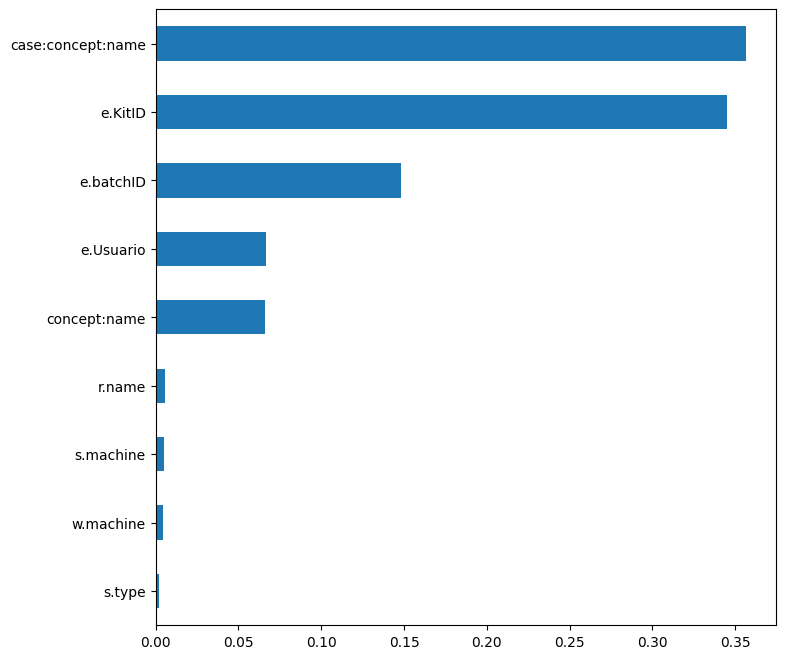

In [86]:
df_new = data.drop('is_delayed', axis=1)

var_imp = pd.DataFrame({'importance': clf.feature_importances_},
                       index=df_new.columns)

var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False)

In [87]:
print(var_imp.sort_values(by='importance'))

                   importance
s.type               0.002264
w.machine            0.004720
s.machine            0.005279
r.name               0.005973
concept:name         0.066049
e.Usuario            0.066451
e.batchID            0.147947
e.KitID              0.344787
case:concept:name    0.356529


In [88]:
count = 0
accur = []
for i in clf.predict(X_test):
    if i == y[count]:
        accur.append(1)
    else:
        accur.append(0)
    count += 1

print(sum(accur) / len(accur))

0.6488633855661002


In [89]:
# Implementation of Random Forest Classifier
#clf = RandomForestClassifier(random_state=75)

# fit model with 5-fold Cross Validation
result = cross_validate(clf, X_train, y_train)  # (defaults) is 5-fold CV

In [90]:
# print evaluation metrics
print('fit_time:', result['fit_time'])
print('score_time:', result['score_time'])
print('test_score:', result['test_score'])
print('mean accuracy:', sum(result['test_score']) / len(result['test_score']))

fit_time: [1.39905906 1.38200307 1.46934676 1.39711213 1.38130999]
score_time: [0.06091285 0.07442808 0.06093216 0.06029272 0.05969882]
test_score: [0.92968627 0.9271638  0.92810973 0.93126281 0.92148825]
mean accuracy: 0.9275421724735932
